# Logistic Regression using MNIST

We'll use the famous [MNIST Handwritten Digits Database](http://yann.lecun.com/exdb/mnist/) for training. It consists of 28x28 grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.
![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

Import `torch` and `torchvision`. 

`torchvision` contains some utilities for working with image data. It also provides helper classes, to download and import popular datasets like MNIST automatically.

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

import numpy as np

In [2]:
# Download dataset for training
dataset = MNIST(root='data/', download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The above command downloads the data (the first time it is run) to the `data/` directory (Check Files) and creates a PyTorch `Dataset`. On subsequent executions, the download is skipped as the data is already downloaded. 

In [3]:
len(dataset)

60000

The dataset has 60,000 images used to train the model. There is also an additional test set of 10,000 images used for testing and evaluating the model. We can create the test dataset using the `MNIST` class by passing `train=False` to the constructor.

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

A sample in the dataset looks as follows

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FB10F798650>, 5)

It is an image of size 28x28. The image is an object of class `PIL.Image.Image`,which is a part of Python imaging library **Pillow**. We can use `matplotlib` to view the image in our Colab notebook

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

`%matplotlib inline` indicates to Colab that we want to plot the graphs within the notebook.

Label: 5


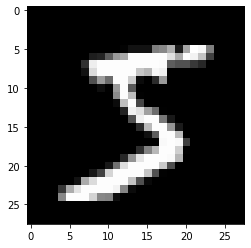

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

PyTorch doesn't know how to work with images in their raw form. So, we need to convert these images to Tensors. We do this by specifying a transform while creating our dataset.

In [8]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [9]:
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [10]:
# Example
img_tensor, label = dataset[0]
#print(img_tensor)
print(img_tensor.shape, label) 

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first index/dimension corresponds to colour channel. This is a grayscale image and hence has only one colour channel. An RGB image has 3 channels each for R, G and B.

If we print the `img_tensor`, we can view the array representation. The values range from 0 to 1 - 0 corresponds to black and 1 to white.

We can also print and show a specific part of an image as follows:

Image Tensor: tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
Image Section:


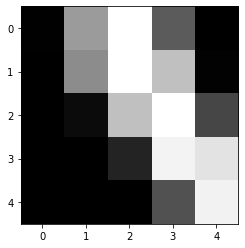

In [11]:
print(f'Image Tensor: {img_tensor[0,10:15,10:15]}\nImage Section:')
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')


Now, for training our model, we need to split the dataset into 3 parts:
* Training Set
* Validation Set
* Test Set

**Validation set** is used to evaluate the model during training - for hyperparameter tuning, etc.

For obtaining our validation set, let us randomly choose 20% of images from our training set of 60000 images i.e., we will be using 48000 images for training and 12000 images for validation.

In [12]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [48000, 12000])
len(train_ds), len(val_ds)

# Alternately
'''import numpy as np

def split_indices(n,val_pct):
  # Determine the size of validation set
  n_val = int(val_pct*n)
  # Create a random permutation of 0 to n-1
  indices = np.random.permutation(n)
  # Pick first n_val indices for validation set
  return indices[n_val:], indices[:n_val]

train_indices, val_indices = split_indices(len(dataset),val_pct=0.2)'''

'import numpy as np\n\ndef split_indices(n,val_pct):\n  # Determine the size of validation set\n  n_val = int(val_pct*n)\n  # Create a random permutation of 0 to n-1\n  indices = np.random.permutation(n)\n  # Pick first n_val indices for validation set\n  return indices[n_val:], indices[:n_val]\n\ntrain_indices, val_indices = split_indices(len(dataset),val_pct=0.2)'

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [13]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. 

Since the validation data loader is used only for evaluating the model, there is no need to shuffle the images. 

## Model
* **Logistic regression** model is almost identical to a Linear regression model. It contains weights and bias matrices, and the output is obtained using matrix operations (`y = x @ w.t() + b`). 

* We can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [14]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [15]:
print(model.weight)
print(model.weight.shape)

Parameter containing:
tensor([[-0.0166, -0.0125,  0.0327,  ...,  0.0347, -0.0356, -0.0169],
        [ 0.0033, -0.0295, -0.0227,  ...,  0.0177, -0.0047,  0.0190],
        [ 0.0053,  0.0264, -0.0014,  ..., -0.0189, -0.0140,  0.0266],
        ...,
        [-0.0121,  0.0009, -0.0212,  ...,  0.0021,  0.0060, -0.0017],
        [-0.0180,  0.0281,  0.0233,  ...,  0.0156, -0.0008,  0.0154],
        [ 0.0107,  0.0295, -0.0073,  ...,  0.0199, -0.0172, -0.0213]],
       requires_grad=True)
torch.Size([10, 784])


In [16]:
print(model.bias)
print(model.bias.shape)

Parameter containing:
tensor([-0.0112, -0.0247, -0.0135,  0.0073,  0.0102,  0.0284,  0.0002,  0.0063,
         0.0084, -0.0351], requires_grad=True)
torch.Size([10])


Therefore, there are a total of 784x10 + 10 = 7850 parameters in our model. Let's generate some outputs using the model. we'll take the first batch of 128 images and pass them to our model.

In [17]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([0, 4, 4, 6, 5, 4, 2, 0, 6, 0, 5, 5, 0, 6, 1, 0, 1, 1, 2, 6, 6, 3, 5, 7,
        6, 2, 1, 3, 9, 7, 5, 8, 3, 1, 7, 0, 6, 4, 6, 2, 3, 1, 3, 4, 8, 9, 2, 4,
        9, 4, 8, 1, 7, 8, 0, 4, 6, 0, 6, 7, 1, 4, 4, 7, 4, 6, 9, 2, 9, 7, 8, 1,
        1, 4, 4, 9, 7, 3, 6, 0, 2, 3, 8, 7, 1, 9, 4, 2, 0, 7, 3, 9, 4, 2, 6, 0,
        4, 6, 6, 6, 9, 6, 2, 0, 0, 1, 1, 3, 4, 1, 2, 6, 1, 7, 4, 3, 4, 2, 0, 8,
        2, 8, 3, 6, 1, 1, 2, 1])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [18]:
images.reshape(batch_size,input_size).shape

torch.Size([128, 784])

This leads to an error because our input data does not have the right shape. Our images have a shape of 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use `.reshape`, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. 

To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch.

In [19]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size,num_classes)

  def forward(self,xb):
    xb = xb.reshape(-1,input_size)
    out = self.linear(xb)
    return out

model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, input_size)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [20]:
print(model.linear)
print('\n')
print(f'Weights: {model.linear.weight}, Size: {model.linear.weight.shape}\n')
print(f'Biases: {model.linear.bias}, Size: {model.linear.bias.shape}\n')
list(model.parameters())

Linear(in_features=784, out_features=10, bias=True)


Weights: Parameter containing:
tensor([[ 0.0206,  0.0291, -0.0148,  ..., -0.0271,  0.0177, -0.0310],
        [-0.0063, -0.0327, -0.0147,  ...,  0.0086,  0.0027,  0.0295],
        [ 0.0009,  0.0186, -0.0167,  ..., -0.0152, -0.0267,  0.0039],
        ...,
        [ 0.0064, -0.0264, -0.0129,  ..., -0.0105,  0.0055,  0.0282],
        [-0.0333, -0.0237, -0.0112,  ..., -0.0124, -0.0302,  0.0266],
        [ 0.0052, -0.0047, -0.0289,  ...,  0.0075,  0.0053, -0.0345]],
       requires_grad=True), Size: torch.Size([10, 784])

Biases: Parameter containing:
tensor([ 0.0172,  0.0068, -0.0045, -0.0299, -0.0233, -0.0015, -0.0045, -0.0080,
        -0.0347, -0.0191], requires_grad=True), Size: torch.Size([10])



[Parameter containing:
 tensor([[ 0.0206,  0.0291, -0.0148,  ..., -0.0271,  0.0177, -0.0310],
         [-0.0063, -0.0327, -0.0147,  ...,  0.0086,  0.0027,  0.0295],
         [ 0.0009,  0.0186, -0.0167,  ..., -0.0152, -0.0267,  0.0039],
         ...,
         [ 0.0064, -0.0264, -0.0129,  ..., -0.0105,  0.0055,  0.0282],
         [-0.0333, -0.0237, -0.0112,  ..., -0.0124, -0.0302,  0.0266],
         [ 0.0052, -0.0047, -0.0289,  ...,  0.0075,  0.0053, -0.0345]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0172,  0.0068, -0.0045, -0.0299, -0.0233, -0.0015, -0.0045, -0.0080,
         -0.0347, -0.0191], requires_grad=True)]

In [21]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:5].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0296,  0.2195,  0.2520,  0.4365, -0.1027, -0.0537,  0.0031,  0.0519,
         -0.1447,  0.2438],
        [-0.0141, -0.4189, -0.2236, -0.1855, -0.2497,  0.1151,  0.4496,  0.2857,
         -0.3106,  0.1856],
        [ 0.1714,  0.3870,  0.2080,  0.1459, -0.1831, -0.2031, -0.0700, -0.0031,
         -0.1093, -0.0517],
        [ 0.0144, -0.0437,  0.0302,  0.0041, -0.2208, -0.0715,  0.0880,  0.3751,
         -0.2200, -0.1879],
        [ 0.3019,  0.5956,  0.3850,  0.0759,  0.1392,  0.0192,  0.1328,  0.2057,
         -0.1969, -0.3266]])


For each of the 128 input images, we get 10 outputs, one for each class. But we woulod like to represent outputs as probabilities, which is not the case now, as seen above.

To convert output rows to probabilities, we use the [softmax function](https://towardsdatascience.com/softmax-activation-function-how-it-actually-works-d292d335bd78)

While it's easy to implement the softmax function, we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors.

In [22]:
import torch.nn.functional as F

The softmax function is included in the `torch.nn.functional` package and requires us to specify a dimension along which the function should be applied.

In [23]:
# Apply softmax for each output row
probs = F.softmax(outputs,dim=1)

print("Sample Probabilities:\n", probs[0:3].data)
print("Sum: ", torch.sum(probs[0]).item())

Sample Probabilities:
 tensor([[0.0923, 0.1116, 0.1153, 0.1387, 0.0809, 0.0849, 0.0899, 0.0944, 0.0776,
         0.1144],
        [0.0985, 0.0657, 0.0799, 0.0830, 0.0778, 0.1121, 0.1566, 0.1329, 0.0732,
         0.1203],
        [0.1133, 0.1406, 0.1176, 0.1105, 0.0795, 0.0779, 0.0890, 0.0952, 0.0856,
         0.0907]])
Sum:  1.0


We can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using `torch.max`, which returns each rows' largest element and the corresponding index.

In [24]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([3, 6, 1, 7, 1, 0, 1, 1, 0, 1, 2, 6, 7, 1, 1, 1, 7, 2, 6, 7, 6, 7, 6, 6,
        7, 0, 7, 2, 2, 7, 3, 6, 2, 1, 6, 7, 0, 6, 1, 1, 6, 1, 3, 9, 1, 1, 1, 1,
        7, 2, 6, 0, 2, 2, 7, 6, 0, 2, 1, 0, 1, 1, 3, 1, 1, 1, 1, 7, 3, 0, 1, 1,
        0, 6, 7, 3, 0, 7, 6, 1, 2, 7, 6, 6, 1, 2, 1, 7, 1, 2, 6, 1, 2, 1, 1, 1,
        6, 6, 1, 3, 1, 6, 5, 7, 1, 6, 1, 1, 7, 6, 1, 6, 2, 6, 6, 6, 1, 0, 6, 0,
        6, 2, 3, 6, 6, 1, 6, 6])
tensor([0.1387, 0.1566, 0.1406, 0.1467, 0.1538, 0.1269, 0.1386, 0.1481, 0.1201,
        0.1400, 0.1484, 0.1502, 0.1222, 0.1422, 0.1333, 0.1350, 0.1266, 0.1298,
        0.1351, 0.1243, 0.1394, 0.1355, 0.1478, 0.1356, 0.1530, 0.1406, 0.1374,
        0.1320, 0.1595, 0.1439, 0.1261, 0.1493, 0.1255, 0.1185, 0.1324, 0.1267,
        0.1247, 0.1235, 0.1368, 0.1329, 0.1536, 0.1221, 0.1170, 0.1095, 0.1314,
        0.1173, 0.1405, 0.1289, 0.1322, 0.1340, 0.1421, 0.1239, 0.1371, 0.1521,
        0.1259, 0.1221, 0.1286, 0.1337, 0.1303, 0.1213, 0.1433, 0.1407, 0.1223,
       

In [25]:
labels

tensor([5, 7, 6, 2, 8, 1, 3, 2, 1, 1, 2, 7, 5, 3, 1, 3, 5, 0, 7, 3, 7, 5, 6, 6,
        0, 1, 5, 0, 2, 3, 4, 9, 1, 0, 5, 0, 5, 7, 6, 8, 8, 1, 5, 8, 6, 1, 8, 6,
        5, 0, 7, 9, 8, 6, 0, 4, 3, 1, 1, 9, 1, 1, 5, 5, 1, 2, 5, 3, 9, 4, 1, 8,
        2, 4, 3, 9, 2, 3, 3, 2, 6, 5, 9, 0, 8, 2, 1, 0, 3, 6, 7, 0, 0, 1, 0, 3,
        4, 8, 1, 4, 2, 7, 7, 5, 3, 9, 1, 3, 3, 9, 8, 6, 8, 8, 9, 9, 5, 7, 4, 7,
        6, 9, 5, 3, 7, 4, 9, 6])

Compare these with the actual labels. They are obviously very different because we have just randomly initialized weights and biases. We need to now train the model i.e., adjust the parameters to make better predictions.

## Evaluation Metric and Loss Function
Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions. 

In [26]:
torch.sum(preds==labels)

tensor(21)

This means that 21 (will change for every run) out of 128 labels are predicted correctly. So we can define accuracy as follows

In [27]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

accuracy(outputs,labels)

tensor(0.1641)

The `==` operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing `True` for unequal elements and `False` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy. 

We can't use accuracy as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but **not** as a loss function. 

A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the **log** of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [28]:
loss_fn = F.cross_entropy

In [29]:
loss = loss_fn(outputs,labels)
loss

tensor(2.2809, grad_fn=<NllLossBackward>)

Way to interpret the resulting number e.g. `2.3019` is look at `e^-2.3019` which is around `0.1` as the predicted probability of the correct label, on average. **Lower the loss, better the model.**

## Training the model

The training process is identical to linear regression, with the addition of a validation phase, to evaluate the model in each epoch. The pseudocode is as follows:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
```

Some parts of the training loop are specific to the specific problem we're solving (e.g. loss function, metrics etc.), whereas others are generic and can be applied to any deep learning problem. 



We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.

In [30]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The `fit` function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (hyperparameters), need to be picked in advance while training ML models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time.

Let's define the `evaluate` function, used in the validation phase of `fit`.

In [31]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


Finally, let's redefine the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and `evaluate`.

In [32]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Before training the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.


In [33]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.05488142743706703, 'val_loss': 2.3700780868530273}

The initial accuracy is around 5.5% (changes every run), which one might expect from a randomly initialized model.

Now, Let's train for five epochs and look at the results.

In [34]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9839, val_acc: 0.6227
Epoch [1], val_loss: 1.7137, val_acc: 0.7160
Epoch [2], val_loss: 1.5117, val_acc: 0.7517
Epoch [3], val_loss: 1.3584, val_acc: 0.7732
Epoch [4], val_loss: 1.2398, val_acc: 0.7919


With just 5 epochs of training, the model has reached an accuracy of around 80% on the validation set. We can improve this by training for a few more epochs.

In [35]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1462, val_acc: 0.8018
Epoch [1], val_loss: 1.0708, val_acc: 0.8122
Epoch [2], val_loss: 1.0091, val_acc: 0.8186
Epoch [3], val_loss: 0.9575, val_acc: 0.8237
Epoch [4], val_loss: 0.9139, val_acc: 0.8277


In [36]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8765, val_acc: 0.8314
Epoch [1], val_loss: 0.8441, val_acc: 0.8339
Epoch [2], val_loss: 0.8157, val_acc: 0.8369
Epoch [3], val_loss: 0.7907, val_acc: 0.8392
Epoch [4], val_loss: 0.7684, val_acc: 0.8416


In [37]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7483, val_acc: 0.8433
Epoch [1], val_loss: 0.7302, val_acc: 0.8442
Epoch [2], val_loss: 0.7139, val_acc: 0.8459
Epoch [3], val_loss: 0.6990, val_acc: 0.8472
Epoch [4], val_loss: 0.6853, val_acc: 0.8492


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. 

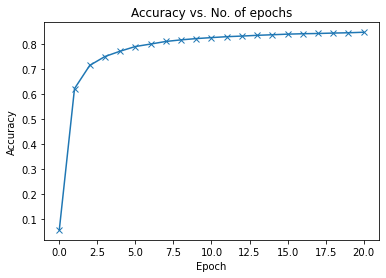

In [39]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above plot that the model probably won't cross the 90% even after training for a long time. 

One possible reason for this is that the learning rate might be too high. The model's parameters may be bouncing around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. Our hypothesis was that, we assumed the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not be a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

## Testing with individual images

In [40]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Here is a sample image from the test dataset

Shape: torch.Size([1, 28, 28])
Label: 7


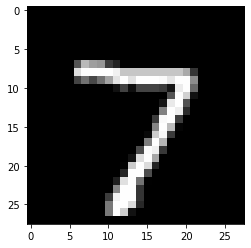

In [41]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [42]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Label: 7 , Predicted: 7


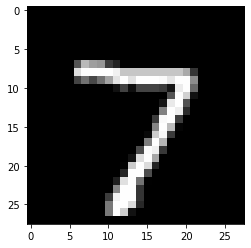

In [43]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


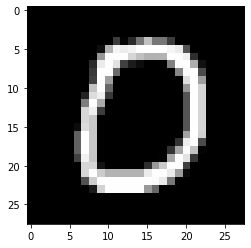

In [44]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


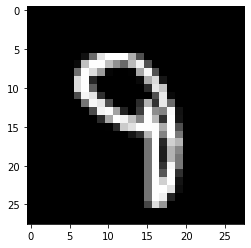

In [45]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


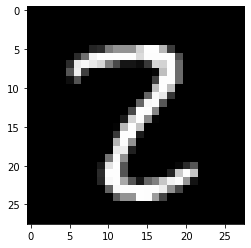

In [46]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's look at the overall loss and accuracy of the model on the test set.

In [47]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8573242425918579, 'val_loss': 0.6515902280807495}

## Saving and loading the model

In [48]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [49]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0243,  0.0129,  0.0147,  ...,  0.0313,  0.0038, -0.0035],
                      [ 0.0309,  0.0061,  0.0232,  ...,  0.0260,  0.0330,  0.0064],
                      [-0.0323, -0.0092, -0.0100,  ...,  0.0127,  0.0013,  0.0154],
                      ...,
                      [-0.0079,  0.0045, -0.0171,  ..., -0.0139,  0.0288,  0.0334],
                      [ 0.0019,  0.0287,  0.0244,  ...,  0.0080, -0.0075, -0.0024],
                      [ 0.0321,  0.0170,  0.0285,  ...,  0.0087, -0.0005,  0.0015]])),
             ('linear.bias',
              tensor([-0.0252,  0.1082, -0.0500, -0.0130,  0.0080,  0.0234, -0.0098,  0.0449,
                      -0.0571, -0.0383]))])

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [50]:
model2 = MnistModel()

In [51]:
model2.state_dict() # Randomly initialized model

OrderedDict([('linear.weight',
              tensor([[-0.0142,  0.0039,  0.0135,  ...,  0.0125, -0.0066,  0.0290],
                      [ 0.0179, -0.0124, -0.0322,  ..., -0.0191,  0.0191,  0.0331],
                      [-0.0171,  0.0241,  0.0208,  ..., -0.0165,  0.0087,  0.0250],
                      ...,
                      [-0.0085, -0.0182,  0.0294,  ..., -0.0011,  0.0229, -0.0132],
                      [-0.0004,  0.0148, -0.0304,  ...,  0.0127,  0.0189,  0.0068],
                      [ 0.0275,  0.0202,  0.0290,  ..., -0.0308,  0.0230, -0.0024]])),
             ('linear.bias',
              tensor([ 0.0137,  0.0033,  0.0023,  0.0317,  0.0340, -0.0027, -0.0167, -0.0328,
                      -0.0268, -0.0341]))])

In [52]:
evaluate(model2, test_loader)

{'val_acc': 0.12812499701976776, 'val_loss': 2.3194963932037354}

Again, since this is a randomly initialized model, we expect such performance.

Now, Let's load our trained model into `model2`

In [53]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0243,  0.0129,  0.0147,  ...,  0.0313,  0.0038, -0.0035],
                      [ 0.0309,  0.0061,  0.0232,  ...,  0.0260,  0.0330,  0.0064],
                      [-0.0323, -0.0092, -0.0100,  ...,  0.0127,  0.0013,  0.0154],
                      ...,
                      [-0.0079,  0.0045, -0.0171,  ..., -0.0139,  0.0288,  0.0334],
                      [ 0.0019,  0.0287,  0.0244,  ...,  0.0080, -0.0075, -0.0024],
                      [ 0.0321,  0.0170,  0.0285,  ...,  0.0087, -0.0005,  0.0015]])),
             ('linear.bias',
              tensor([-0.0252,  0.1082, -0.0500, -0.0130,  0.0080,  0.0234, -0.0098,  0.0449,
                      -0.0571, -0.0383]))])

You can see that the trained paramteres have been loaded into our new `model2`

In [54]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.8573242425918579, 'val_loss': 0.6515902280807495}

## Summary and Further Reading

We covered:

* Working with images in PyTorch (using the MNIST dataset).
* Splitting a dataset into training, validation and test sets.
* Creating PyTorch models with custom logic by extending the `nn.Module` class.
* Interpreting model ouputs as probabilities using softmax, and picking predicted labels.
* Picking a good evaluation metric (accuracy) and loss function (cross entropy) for classification problems.
* Setting up a training loop that also evaluates the model using the validation set.
* Testing the model manually on randomly picked examples 
* Saving and loading model checkpoints to avoid retraining from scratch.

**Experiment!**

* Try making the validation set smaller or larger, and see how it affects the model.
* Try changing the learning rate and see if you can achieve the same accuracy in fewer epochs.
* Try changing the batch size. What happens if you use too high a batch size, or too low?
* Modify the `fit` function to also track the overall loss and accuracy on the training set, and see how it compares with the validation loss/accuracy. Can you explain why it's lower/higher?
* Train with a small subset of the data, and see if you can reach a similar level of accuracy.
* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html).
